In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import QFT
import numpy as np


def phi_addition_cc(n, b, factor):
    """Double controlled addition in fourier space:
    |phi(x)> -> |phi(x + factor*b)>"""
    ctrl = QuantumRegister(2, "c")
    reg = QuantumRegister(n, "r")
    addc = QuantumCircuit(ctrl, reg, name="CCPHIADD(%d*%d)" % (b, factor))

    for k in range(0, n):
        addc.append(ccp(factor * get_angle(k, b)), list(ctrl) + [reg[k]])

    return addc



def ccp(theta):
    """Double controlled phase gates using single controlled phase gates."""

    ctrl = QuantumRegister(2, "ctrl")
    q = QuantumRegister(1, "q")
    ccp = QuantumCircuit(ctrl, q, name="CCP(%d)" % theta)

    ccp.cp(theta / 2, ctrl[1], q)
    ccp.cx(ctrl[0], ctrl[1])
    ccp.cp(-theta / 2, ctrl[1], q)
    ccp.cx(ctrl[0], ctrl[1])
    ccp.cp(theta / 2, ctrl[0], q)

    return ccp


def phi_addition_controlled(n, b, factor):
    """
    Single controlled addition in Fourier space:
    |phi(x)> -> |phi(x + factor*b)>
    See: Thomas G. Draper. Addition on a quantum computer.
    """
    return phi_addition_controlled_ignorebits(n, b, factor, 0)


def phi_addition_controlled_ignorebits(n, b, factor, ignorebits):
    """Single controlled addition in Fourier space:
    |phi(x)> -> |phi(x + factor*b)>
    ignorebits allows to remove all operations on the qubits < ignorebits
    (all less significant ones). Is used in the implementation of montgomery
    multiplication.
    Using approach from:
    Thomas G. Draper. Addition on a quantum computer.
    """
    ctrl = QuantumRegister(1, "c")
    reg = QuantumRegister(n - ignorebits, "r")
    addc = QuantumCircuit(ctrl, reg, name="CPHIADD(%d*%d,ignore=<%d)" % (b, factor, ignorebits))
    if ignorebits <= 0:
        addc = QuantumCircuit(ctrl, reg, name="CPHIADD(%d*%d)" % (b, factor))

        # addition in y-fourier space
    for k in range(0, n):
        if k < ignorebits:
            continue
        # rotate bit k by b*pi/(2^k+1)
        addc.cp(factor * get_angle(k, b), ctrl, reg[k - ignorebits])

    return addc



def add_draper(n, b, factor):
    """Adder |x> -> |x + factor * b> using adder in fourier space.
    QFT is performed without swaps (not necessary since the adder
    can just be appended exactly as needed for the result."""
    areg = QuantumRegister(n, "a")

    adder = QuantumCircuit(areg, name="ADD(%d*%d)" % (b, factor))

    # dont do swaps so QFT is as in paper
    adder.append(QFT(n, do_swaps=False), areg)

    adder.append(phi_add_builtin(n, b, factor), areg)

    adder.append(QFT(n, do_swaps=False).inverse(), areg)

    return adder


def get_angle(k, b):
    """Computes the angle of rotation based on the input constant.
    = b*pi/2^k"""
    # rotate by b*pi/2^k
    return b * np.pi / (2 ** k)


def phi_add_builtin(n, b, factor):
    """Adder |phi(x)> -> |phi(x + factor*b)>.
    As opposed to phi_add_builtin_singlegates, only one rotation is performed
    for each qubit (since b is fully known in advance this rotation can be
    precomputed).
    See: Thomas G. Draper. Addition on a quantum computer."""
    areg = QuantumRegister(n, "phi_a")

    add = QuantumCircuit(areg, name="phiADD(%d*%d)" % (b, factor))

    for k in range(0, n):
        angle = get_angle(k, b)
        add.p(factor * angle, areg[k])

    return add


def phi_add_builtin_singlegates(n, b, factor):
    """
    |phi(x)> -> |phi(x + factor*b)>
    b and factor are builtin to the circuit.
    For debug/visualisation: Adder in Fourier space, where each
    input bit of the constant is treated as one qubit (although 'it is
    not there') - mimics the layout in:
    Thomas G. Draper. Addition on a quantum computer.
    factor allows simple creation of a subtraction (factor = -1)."""
    areg = QuantumRegister(n, "phi_a")

    add = QuantumCircuit(areg, name="phiADD(%d*%d)" % (b, factor))

    b_bin = np.binary_repr(b, n)
    # print("b: %s" % b_bin)
    # reverse the binary repr so the accessing the required values is easier
    b_bin = b_bin[::-1]

    for k in range(0, n):
        # apply all angles for a_k
        for i in range(0, k + 1):
            if b_bin[i] == '1':
                r = k - i + 1
                add.p(factor * 2 * np.pi / 2 ** r, areg[k])

    return add

In [7]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import QFT


def phi_add_mod_N_cc(n, y, N):
    """Modular addition in fourier space as described in:
    Stephane Beauregard. Circuit for Shor’s algorithm using 2n+3 qubits.
    Uses two control qubits.
    |phi(a)>|0> -> |phi((a+y) mod N)>|0>.
    Register sizes:
    2 control
    n |phi(a)> -> |phi((a+y) mod N)>
    1 ancilla
    """
    ctrl = QuantumRegister(2, "ctrl")
    reg = QuantumRegister(n, "a")  # Holds the input
    aux = QuantumRegister(1, "aux")  # Holds the msb after the first step to use as control later

    qc_add = QuantumCircuit(ctrl, reg, aux, name="CCADD(%d)MOD(%d)" % (y, N))

    iqft = QFT(n, do_swaps=False).inverse()
    qft = QFT(n, do_swaps=False)

    # add y
    qc_add.append(phi_addition_cc(n, y, 1), list(ctrl) + list(reg))

    # decrease by N
    qc_add.append(phi_add_builtin(n, N, -1), reg)

    # iqft
    qc_add.append(iqft, reg)

    # msb is in highest register
    qc_add.cx(reg[n - 1], aux[0])

    # QFT again, because we add in fourier space again
    qc_add.append(qft, reg)

    # controlled add
    cadd = phi_addition_controlled(n, N, 1)
    qc_add.append(cadd, [aux[0]] + list(reg))  # have to reorder here so the last bit controls the gate

    # substract y again
    qc_add.append(phi_addition_cc(n, y, -1), list(ctrl) + list(reg))

    # do inv. qft to get msb again
    qc_add.append(iqft, reg)

    # flip msb
    qc_add.x(reg[n - 1])

    # flip aux according to msb
    qc_add.cx(reg[n - 1], aux[0])

    # flip it back
    qc_add.x(reg[n - 1])

    # back to fourier space
    qc_add.append(qft, reg)

    # Now add y back again to get to the proper result again
    qc_add.append(phi_addition_cc(n, y, 1), list(ctrl) + list(reg))

    return qc_add


def phi_add_mod_N(n, y, N):
    """Modular addition in fourier space as described in:
    Stephane Beauregard. Circuit for Shor’s algorithm using 2n+3 qubits.
    |phi(a)>|0> -> |phi((a+y) mod N)>|0>.
    Register sizes:
    n |phi(a)> -> |phi((a+y) mod N)>
    1 ancilla
    """
    reg = QuantumRegister(n, "a")  # Holds the input
    aux = QuantumRegister(1, "aux")  # Holds the msb after the first step to use as control later
    aux_index = n

    qc_add = QuantumCircuit(reg, aux, name="ADD(%d)MOD(%d)" % (y, N))

    iqft = QFT(n, do_swaps=False).inverse()
    qft = QFT(n, do_swaps=False)

    # add y
    qc_add.append(phi_add_builtin(n, y, 1), reg)

    # decrease by N
    qc_add.append(phi_add_builtin(n, N, -1), reg)

    # iqft
    qc_add.append(iqft, reg)

    # msb is in highest register
    qc_add.cx(reg[ n -1], aux[0])

    # QFT again, because we add in fourier space again
    qc_add.append(qft, reg)

    # controlled add
    cadd = phi_addition_controlled(n, N, 1)
    qc_add.append(cadd, [aux_index]+list(reg))  # have to reorder here so the last bit controls the gate

    # substract y again
    qc_add.append(phi_add_builtin(n, y, -1), reg)

    # do inv. qft to get msb again
    qc_add.append(iqft, reg)

    # flip msb
    qc_add.x(reg[n-1])

    # flip aux according to msb
    qc_add.cx(reg[n-1], aux[0])

    # flip it back
    qc_add.x(reg[n-1])

    # back to fourier space
    qc_add.append(qft, reg)

    # Now add y back again to get to the proper result again
    qc_add.append(phi_add_builtin(n, y, 1), reg)

    return qc_add

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import QFT
import math


def mult_mod_N_c(a, N, size_requested=None):
    """Controlled in-place multiplication:
    |x>|0> -> |ax mod N>|0>
    As presented in: Stephane Beauregard. Circuit for Shor’s algorithm using 2n+3 qubits.
    Register sizes:
    1 control
    n input=output |x> -> |ax mod N>
    n+2 ancilla
    n can either be supplied (size_requested) or will be calulated as ceil(ld(N)).
    The module N should be co-prime to the input constant a."""
    size = 0
    if size_requested == None:
        size = math.ceil(math.log(N, 2))
    else:
        size = size_requested

    size_x = size
    size_b = size + 1

    control = QuantumRegister(1, "c")
    reg_x = QuantumRegister(size_x, "x")
    reg_b = QuantumRegister(size_b, "b")
    # The one ancillary register for addition
    reg_anc = QuantumRegister(1, "anc")

    u = QuantumCircuit(control, reg_x, reg_b, reg_anc, name="CMUL(%d)MOD(%d)" % (a, N))

    # mult -> ax mod N
    u.append(mult_mod_N_partial_c(a, N, size_x, size_b), u.qubits)

    # controlled swaps
    # swap the bottom with the x register
    for i in range(0, size_x):
        u.cswap(control[0], reg_x[i], reg_b[i])

    # the last bit in b does not have to be swapped since it stays 0 after each addition
    inv_a = pow(a, -1, N)
    u.append(mult_mod_N_partial_c(inv_a, N, size_x, size_b).inverse(), u.qubits)

    return u


def mult_mod_N_partial_c(y, N, size_x, size_b):
    """Controlled out-of-place multiplication as described in
    Stephane Beauregard. Circuit for Shor’s algorithm using 2n+3 qubits.
    Register sizes:
    1 control
    size_x input register |x> -> |x>
    size_b result register |y> -> |y + a*x mod N>
    1 ancilla
    """
    control = QuantumRegister(1, "c")
    reg_x = QuantumRegister(size_x, "x")
    reg_b = QuantumRegister(size_b, "b")
    reg_anc = QuantumRegister(1, "anc")

    mult = QuantumCircuit(control, reg_x, reg_b, reg_anc, name="CMUL0(%d)MOD(%d)" % (y, N))

    # QFT on b
    mult.append(QFT(size_b, do_swaps=False), reg_b)

    # For each x-bit add a controlled addition with 2^k*y
    for k in range(0, size_x):
        adder_gate = phi_add_mod_N_cc(size_b, (2 ** k * y % N), N)
        # the gate at x_k is controlled by the global control and x_k
        # it works on register b + the ancillary bit
        controls = [control[0], reg_x[k]]
        mult.append(adder_gate, controls + list(reg_b) + [reg_anc[0]])

    # IQFT on b
    mult.append(QFT(size_b, do_swaps=False).inverse(), reg_b)

    return mult

In [9]:
from qiskit import QuantumCircuit, QuantumRegister
import math


def mod_exp_brg(n, a, N):
    """Modular exponentiation:
    |x>|y>|0...0> -> |x>|y * a^x mod N>|0...0>
    Register sizes:
    n top register |x> -> |x>
    n bottom register |y> -> |y*a^x mod N>
    n+2 ancilla |0> -> |0>
    See: Stephane Beauregard. Circuit for Shor’s algorithm using 2n+3 qubits.
    """

    # mult register has size 2n+3, where 1 is the control bit
    size_input = 2*math.ceil(math.log(N, 2))+3

    x_reg = QuantumRegister(n, "x")
    input_reg = QuantumRegister(size_input-1, "input") # one bit of the u-gate is control

    circ = QuantumCircuit(x_reg, input_reg, name="%d^x MOD(%d)" % (a, N))

    for i in range(0, n):
        mulgate = mult_mod_N_c(a**(2**i) % N, N)
        circ.append(mulgate, [x_reg[i]] + list(input_reg))

    return circ

In [10]:
from typing import Dict, Optional, Union, Callable

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import QFT


import math
import numpy as np
from abc import ABC, abstractmethod
from fractions import Fraction


def mod_mul_brg(n, a, p):
    return mult_mod_N_c(a, p)


class DiscreteLogMoscaEkert():
    def __init__(self,
                 b: int,
                 g: int,
                 p: int,
                 r: int = -1,
                 n: int = -1,
                 mod_exp_constructor: Callable[[int, int, int], QuantumCircuit] = None,
                 full_run: bool = False,
                 quantum_instance: Optional = None) -> None:
        """
        Args:
            b: Finds discrete logarithm of b with respect to generator g and module p.
            g: Generator.
            p: Prime module.
            r: The order of g if it is known (otherwise it will be calculated)
            n: The size of the top register, if not given it will be inferred from the module p
            mod_exp_constructor: Function returns modular exponentiation circuit: (n, a, p) -> QuantumCircuit
                (n = size of top register)
            run_full (default: False), if set to True, the algorithm will not stop after finding the result,
                but will examine all results and log the probability
            quantum_instance: Quantum Instance or Backend
        """
        self._b = b
        self._g = g
        self._p = p
        self._r = r
        self._n = n
        self._full_run = full_run
        self._quantum_instance = quantum_instance

        if mod_exp_constructor is None:
            self._mod_exp_constructor = mod_exp_brg
        else:
            self._mod_exp_constructor = mod_exp_constructor

    @abstractmethod
    def _exec_qc(self, n, b, g, p, r, mod_exp_constructor, quantum_instance, shots) -> [(int, int, int)]:
        pass

    def get_circuit(self):
        if self._n == -1:
            n = math.ceil(math.log(self._p, 2))
        else:
            n = self._n
        print("constructing with size n=", n)
        return self._construct_circuit(n, self._b, self._g, self._p, self._r, self._mod_exp_constructor)

    @abstractmethod
    def _construct_circuit(self, n: int, b: int, g: int, p: int, r: int, mod_exp_constructor) -> QuantumCircuit:
        pass

    @staticmethod
    def find_period(result_list: [(int, int, int)], n: int, p: int, g: int) -> int:
        """The order of the generator is not given, it has to be determined.
        The list of results for the whole circuit will be used, since the
        measurement of stage1 allows for phase estimation of the operator
        (similar to Shor's algorithm for prime factorization)."""
        smallest_fitting_denominator = p+1  # init to p+1 (sth larger than the real result)
        for (y1, _, _) in result_list:
            meas_div = y1/(2**n)
            frac_meas = Fraction(meas_div).limit_denominator(p - 1)

            # check if denominator fits
            r_candidate = frac_meas.denominator
            if g**r_candidate % p == 1:
                # fits
                if r_candidate < smallest_fitting_denominator:
                    smallest_fitting_denominator = r_candidate

        print("Found r=", smallest_fitting_denominator)
        return smallest_fitting_denominator

    # Manually reproduced since quantumalgorithm interface changed
    def run(self) -> Dict:
        return self._run()

    def _run(self) -> Dict:
        # construct circuit

        # size of top register is enough to hold all values mod p
        if self._n == -1:
            n = math.ceil(math.log(self._p, 2))
        else:
            n = self._n
        print("constructing with size n=", n)
        # print("top register size: ", n)

        if self._quantum_instance is not None:
            shots = 1

            result_list = self._exec_qc(n, self._b, self._g, self._p, self._r, self._mod_exp_constructor,
                                        self._quantum_instance, shots)

            num_fail = 0
            num_success = 0

            correct_m = -1

            for (y1, y2, freq) in result_list:
                if self._r == -1:
                    # period has to be calculated
                    self._r = self.find_period(result_list, n, self._p, self._g)

                # k is inferred from the measurement result from first stage
                k = int(round((y1 * self._r) / (2 ** n), 0))
                # print("k=", k)

                # m (the discrete log) is calculated by using the congruence:
                # ((km mod r)/r)*2^n = m_stage2
                # v = m_stage2*r/2^n
                v = (y2 * self._r) / (2 ** n)
                # print("v=", v)  # = km mod r

                # k inverse exists?
                if np.gcd(k, self._r) != 1:
                    # print("No inverse for k = fail")
                    num_fail += freq
                else:
                    kinv = pow(k, -1, self._r)
                    # print("kInv=", kinv)
                    m = int(round(v * kinv % self._r, 0))
                    # print("found m=", m)

                    # check if this m actually fits
                    if (self._g ** m % self._p) == self._b:
                        num_success += freq
                        # print("found correct m!")
                        correct_m = m
                        if not self._full_run:
                            break
                    else:
                        # print("found wrong m!")
                        num_fail += freq

            print("num_fail:", num_fail)
            print("num_success:", num_success)

            return {"m": correct_m, "success_prob": num_success / shots}

        return {"m": -1, "success_prob": 0}

In [13]:
class DiscreteLogMoscaEkertSeperateRegister(DiscreteLogMoscaEkert):
    def __init__(self,
                 b: int,
                 g: int,
                 p: int,
                 r: int = -1,
                 n: int = -1,
                 mod_exp_constructor: Callable[[int, int, int], QuantumCircuit] = None,
                 full_run: bool = False,
                 quantum_instance: Optional = None) -> None:
        super().__init__(b, g, p, r, n, mod_exp_constructor, full_run, quantum_instance)

    def _exec_qc(self, n, b, g, p, r, mod_exp_constructor, quantum_instance, shots) -> [(int, int, int)]:
        me_circuit = transpile(self._construct_circuit(n, b, g, p, r, mod_exp_constructor),
                               quantum_instance)
        counts = quantum_instance.run(me_circuit, shots=shots).result().get_counts(me_circuit)

        res = list()
        for result in counts.keys():
            # split result measurements
            result_s = result.split(" ")
            m_stage1 = int(result_s[1], 2)
            m_stage2 = int(result_s[0], 2)

            res.append((m_stage1, m_stage2, counts[result]))

        return res

    def _construct_circuit(self, n: int, b: int, g: int, p: int, r: int, mod_exp_constructor) -> QuantumCircuit:
        # infer size of circuit from modular exponentiation circuit
        mod_exp_g = mod_exp_constructor(n, g, p)
        mod_exp_b = mod_exp_constructor(n, b, p)

        iqft = QFT(n).inverse()

        total_circuit_qubits = mod_exp_g.num_qubits
        bottom_register_qubits = total_circuit_qubits - n

        top1reg = QuantumRegister(n, "topstage1")
        top2reg = QuantumRegister(n, "topstage2")
        botreg = QuantumRegister(bottom_register_qubits, "bot")
        meas_stage1 = ClassicalRegister(n, "m1")
        meas_stage2 = ClassicalRegister(n, "m2")

        me_circuit = QuantumCircuit(top1reg, top2reg, botreg, meas_stage1, meas_stage2)

        # H on top
        me_circuit.h(top1reg)

        # 1 on bottom
        me_circuit.x(botreg[0])

        # mod exp g^x mod p
        me_circuit.append(mod_exp_g, list(top1reg) + list(botreg))

        # iqft top
        me_circuit.append(iqft, top1reg)

        # h on top2
        me_circuit.h(top2reg)

        # mod exp b^x' mod p
        me_circuit.append(mod_exp_b, list(top2reg) + list(botreg))

        # iqft top
        me_circuit.append(iqft, top2reg)

        # measure top register (stage 1)
        me_circuit.measure(top1reg, meas_stage1)

        # measurement stage 2
        me_circuit.measure(top2reg, meas_stage2)
        
        me_circuit.draw()

        return me_circuit

order:  6
constructing with size n= 3
Result(backend_name='qasm_simulator', backend_version='0.12.0', qobj_id='', job_id='08bbf744-21b8-42ba-b8aa-819a3ea2d483', success=True, results=[ExperimentResult(shots=20, success=True, meas_level=2, data=ExperimentResultData(counts={'0x19': 1, '0x35': 1, '0x2e': 1, '0xf': 1, '0x2a': 1, '0x17': 1, '0x27': 1, '0x0': 3, '0x36': 1, '0x1f': 3, '0x4': 5, '0x29': 1}), header=QobjExperimentHeader(creg_sizes=[['m1', 3], ['m2', 3]], global_phase=4.638849044546702e-17, memory_slots=6, n_qubits=14, name='circuit-12635', qreg_sizes=[['topstage1', 3], ['topstage2', 3], ['bot', 8]]), status=DONE, seed_simulator=1589956356, metadata={'noise': 'ideal', 'batched_shots_optimization': False, 'measure_sampling': True, 'parallel_shots': 1, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'num_clbits': 6, 'parallel_state_update': 8, 'sample_measure_time': 9.1454e-05, 'num_qubits': 14, 'device': 'CPU', 'input_qubit_map': [

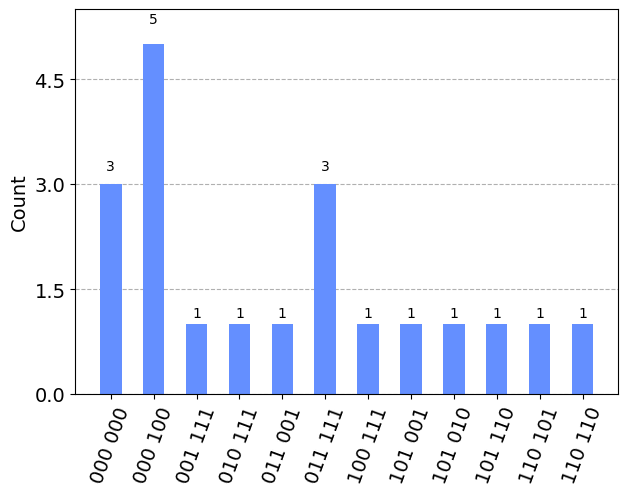

In [17]:
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
import json


def get_order(g, p):
    for x in range(1, p):
        if g**x % p == 1:
            return x

def get_qobj_output(circuit, simulator):
    circsim = transpile(circuit, simulator)

    job = execute(circsim, simulator, shots=20)
    job_res = job.result()

    return job_res

p = 7
g = 3
b = 4
r = get_order(g, p)
print("order: ", r)

simulator = Aer.get_backend('qasm_simulator')

me_algo = DiscreteLogMoscaEkertSeperateRegister(b, g, p, r=r, full_run=True, quantum_instance=simulator)
# me_algo.get_circuit().draw()
res = get_qobj_output(me_algo.get_circuit(), simulator)
print(res)
counts = res.get_counts()
plot_histogram(counts)